# Explaining Model Predictions with Partial Dependence Plots (PDP)

## **1. Introduction**
- In this notebook, we will explore Partial Dependence Plots (PDP), a powerful post hoc explainability method.
PDP helps us understand how a feature or a pair of features impacts the predictions of a machine learning model.

- Partial dependence plots (PDP) show the **dependence between the target response and a set of input features of interest**, marginalizing over the values of all other input features (the ‘complement’ features). Intuitively, we can interpret the partial dependence as the expected target response as a function of the input features of interest.

- Partial dependence plots are global explainability method which considers all instances and shows the global relationship of a feature with the predicted outcome. 
	1.	Model Prediction:
		-	A machine learning model predicts an output  $f(x)$ , where  x  is a vector of features  $x = [x_1, x_2, \dots, x_d]$ .
	2.	Fixing the Feature of Interest:
		- To compute the partial dependence for one feature (e.g.,  $x_s$ ), we fix its value to  $x_s^*$  while allowing all other features ( $x_{-s}$ ) to vary across their observed values in the dataset.
	3.	Averaging Over All Other Features:
		- For each fixed value of the feature of interest  $x_s^*$ , the model predictions are averaged over the observed combinations of the other features  $x_{-s}$ . This removes the influence of the specific values of  $x_{-s}$ , capturing only the marginal effect of  $x_s$.
		
- Mathematically, for a single feature  $x_s$ , the partial dependence is:

	$\hat{f}{\text{PDP}}(x_s^*) = \frac{1}{n} \sum_{i=1}^{n} f(x_s^*, x_{-s}^{(i)})$

where:
- $x_s^*$ : Fixed value of the feature of interest.
- $x_{-s}^{(i)}$ : Observed values of all other features for the i-th data point.
- $n$ : Total number of data points.

This technique was introduced in the following paper:
Friedman, Jerome H. 2001. “Greedy Function Approximation: A Gradient Boosting Machine.” The Annals of Statistics 29 (5): 1189–1232. https://doi.org/10.1214/aos/1013203451.

## **2. Import Necessary Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

## **3. Load and Explore the Dataset**
Here we first load the California Housing dataset

In [2]:
data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# Display dataset summary
print("Dataset Overview:")
display(X.head())
print("\nTarget (y) Overview:")
print(y[:5])

Dataset Overview:


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25



Target (y) Overview:
[4.526 3.585 3.521 3.413 3.422]


## **4. Data Preprocessing**

Split the data into training and test sets

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## **5. Train a Linear Regression Model**

The **interpretability** of linear regression is one of its greatest strengths. The model’s equation offers clear coefficients that illustrate the influence of each independent variable on the dependent variable, enhancing our understanding of the underlying relationships. Its simplicity is a significant advantage; linear regression is transparent, easy to implement, and serves as a foundational concept for more advanced algorithms. Let's initialize and train the model using scikit-learn

In [4]:

model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model Evaluation:\nMean Squared Error: {mse:.2f}\nR-squared: {r2:.2f}")

Model Evaluation:
Mean Squared Error: 0.56
R-squared: 0.58


## **6. Compute Partial Dependence Plots (PDP)**

- Due to the limits of human perception, the size of the set of input features of interest must be small (usually, one or two) thus the input features of interest are usually chosen among the most important features.
- Here we select a feature for one-way PDP visualization. In this case, 'MedInc' - Median Income

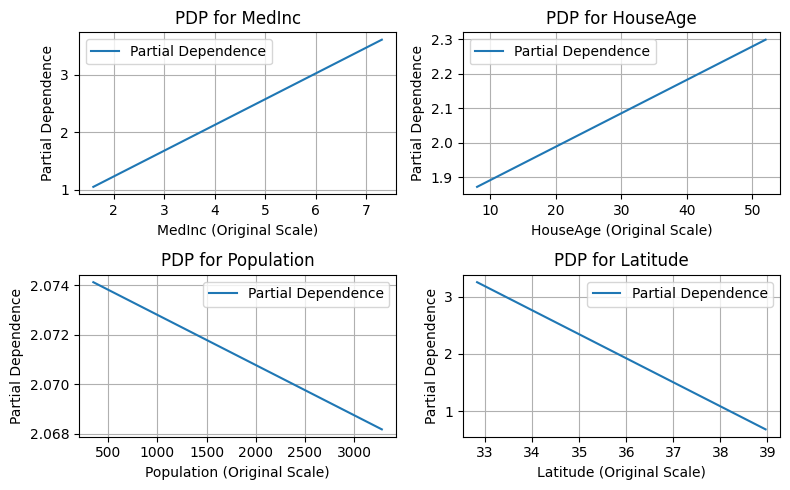

In [5]:

# Features to plot (indices of features)
features_to_plot = [0, 1, 4, 6]  # Example: 'MedInc', 'HouseAge', 'AveRooms', 'AveOccup'
feature_names_to_plot = [data.feature_names[i] for i in features_to_plot]

# Initialize subplots
fig, axes = plt.subplots(2, 2, figsize=(8, 5))  # 2x2 grid of subplots
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Loop through each feature
for i, feature_index in enumerate(features_to_plot):
    # Compute partial dependence
    pdp_results = partial_dependence(
        model,
        X_train_scaled,
        [feature_index],
        grid_resolution=50  # Increase resolution for smoother plots
    )
    
    # Get the scaled feature grid and averaged predictions
    scaled_feature_values = pdp_results['grid_values'][0]  # Feature grid (scaled values)
    averaged_predictions = pdp_results['average'][0]  # Partial dependence values

    # Reverse the scaling for the feature grid
    feature_mean = scaler.mean_[feature_index]  # Mean of the feature
    feature_std = np.sqrt(scaler.var_[feature_index])  # Standard deviation of the feature
    unscaled_feature_values = scaled_feature_values * feature_std + feature_mean  # Reverse scaling

    # Plot PDP on the corresponding subplot
    axes[i].plot(unscaled_feature_values, averaged_predictions, label='Partial Dependence')
    axes[i].set_xlabel(f"{feature_names_to_plot[i]} (Original Scale)")
    axes[i].set_ylabel("Partial Dependence")
    axes[i].set_title(f"PDP for {feature_names_to_plot[i]}")
    axes[i].grid()
    axes[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()

## **7. Two-feature Partial Dependence Plot**

Instead of looking at each feature separately, we can also visualize a two-feature PDP. Here we select two features for PDP (e.g., 'MedInc' and 'AveRooms')

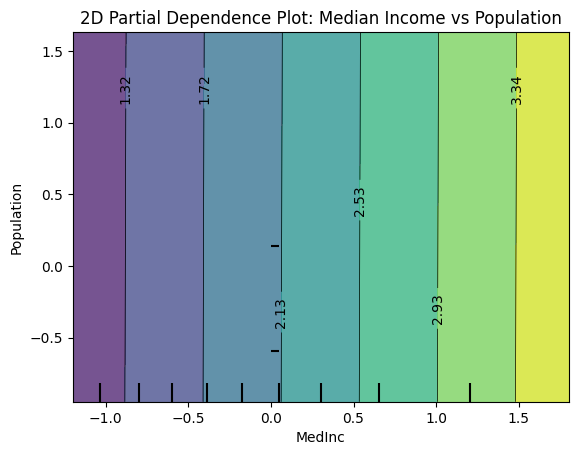

In [6]:
features_to_plot_2d = [(0, 4)]  # Indices of 'MedInc' and 'Population'

# Compute and plot 2D PDP
PartialDependenceDisplay.from_estimator(
    model, X_train_scaled, features_to_plot_2d, feature_names=data.feature_names
)
plt.title("2D Partial Dependence Plot: Median Income vs Population")
plt.show()

## **8.Interpretation**

- Higher Median Income (MedInc): As MedInc increases (moves rightward on the X-axis), the predicted values increase (lighter colors appear), reflecting a positive relationship between median income and the target variable (e.g., house price).
- Population Effect (Population): The Y-axis effect of Population appears weaker since the variation in predicted values along this axis (up-down direction) is relatively smaller compared to MedInc.
- This plot suggests that **MedInc has a stronger influence on predictions than Population**, as the gradient of the color change is primarily along the X-axis.
- The effect of Population appears to be relatively uniform across different levels of MedInc, indicating limited interaction between the two features.
- Dominant Feature: MedInc (Median Income) is the dominant factor influencing the model predictions.


## 9. GradientBoostingRegressor

Simple Linear Regression is too simple a model for many problems. Let's try a more comples ensemble classifier on the same dataset. We now use the GradientBoostingRegressor model. 

Model Evaluation:
Mean Squared Error: 0.29
R-squared: 0.78


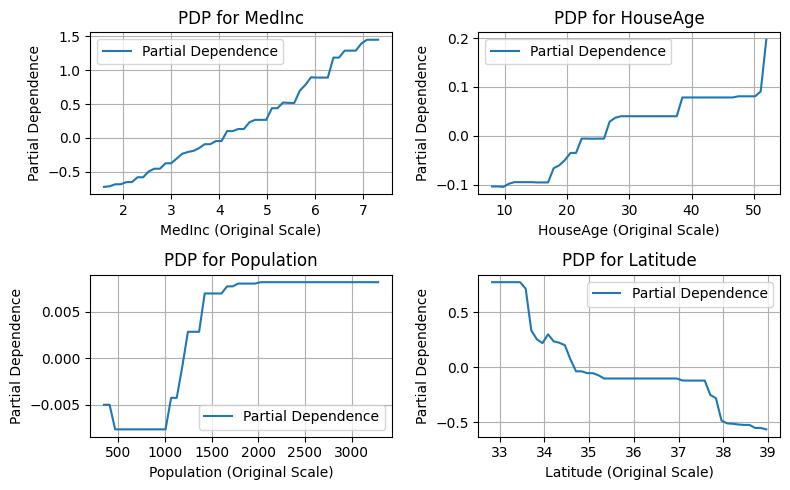

In [7]:
model = GradientBoostingRegressor(learning_rate=0.1,n_estimators=100) 
model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model Evaluation:\nMean Squared Error: {mse:.2f}\nR-squared: {r2:.2f}")

# Features to plot (indices of features)
features_to_plot = [0, 1, 4, 6]  # Example: 'MedInc', 'HouseAge', 'AveRooms', 'AveOccup'
feature_names_to_plot = [data.feature_names[i] for i in features_to_plot]

# Initialize subplots
fig, axes = plt.subplots(2, 2, figsize=(8, 5))  # 2x2 grid of subplots
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Loop through each feature
for i, feature_index in enumerate(features_to_plot):
    # Compute partial dependence
    pdp_results = partial_dependence(
        model,
        X_train_scaled,
        [feature_index],
        grid_resolution=50  # Increase resolution for smoother plots
    )
    
    # Get the scaled feature grid and averaged predictions
    scaled_feature_values = pdp_results['grid_values'][0]  # Feature grid (scaled values)
    averaged_predictions = pdp_results['average'][0]  # Partial dependence values

    # Reverse the scaling for the feature grid
    feature_mean = scaler.mean_[feature_index]  # Mean of the feature
    feature_std = np.sqrt(scaler.var_[feature_index])  # Standard deviation of the feature
    unscaled_feature_values = scaled_feature_values * feature_std + feature_mean  # Reverse scaling

    # Plot PDP on the corresponding subplot
    axes[i].plot(unscaled_feature_values, averaged_predictions, label='Partial Dependence')
    axes[i].set_xlabel(f"{feature_names_to_plot[i]} (Original Scale)")
    axes[i].set_ylabel("Partial Dependence")
    axes[i].set_title(f"PDP for {feature_names_to_plot[i]}")
    axes[i].grid()
    axes[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()


**Interpretations of the PDP for GradientBoostingRegressor model:**

- PDP Medinc:
    - As MedInc increases, the model’s prediction also increases consistently.
    - Median Income is reflected as a significant positive predictor
    - nearlty linear trend indicates model learns a direct relationship between income and target without strong non-linear interactions

- PDP HouseAge
    - step-wise increasing pattern
    - For house ages up to around 30 years, the effect is nearly flat. Beyond this, the partial dependence increases gradually and then sharply for houses over 50 years old.
    - Older houses (50+ years) contribute positively to the target, potentially because older properties might be in more desirable or established areas.

- PDP Population
    - Population has a relatively weak effect on the target variable for smaller values (<1500).
    - For larger populations, the partial dependence stabilizes, suggesting that the model considers blocks with higher populations more favorable, but only up to a certain point.

## **9. Conclusion**

- Partial Dependency Plots are one of the baselines for post-hoc explainability. 
- The main weakness of PDP:
    - the assumption that each feature is independant may be violated in many problems as features may be correlated
    - PDP shows average effects of each feature on the target variable - so it might miss nuances or localized patterns - oversimplyfying main effects
    - cannot capture interactions between features well.
    - PDPD works best for continuous feature, less effective on categorical features
    - PDP is a global explainability tool, so it cannot be used for instance-level local explanations
- Are there better alternatives ?
    - Sure there are. One such technique is Accumulated Average Effects Plot (ALE) which we shall see next.
